In [1]:
import os, glob
import sys
from sys import stderr
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import datetime
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.enable_eager_execution()
from tensorflow.keras import backend as K, preprocessing, \
                             models, layers, optimizers, \
                             utils, callbacks, initializers, \
                             activations, regularizers, applications, \
                             constraints, Model
import numpy as np
import numpy.random as rand
import scipy.fftpack as fft
import six
import cv2 as cv
import pandas as pd
import peakutils
import seaborn as sns
from numpy import linalg as la, random as rand
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tnrange, tqdm_notebook
from jupyterthemes import jtplot

In [2]:
%matplotlib inline
jtplot.reset()
# plt.switch_backend('Agg')
sns.set()
sns.set_context("talk")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100

In [3]:
class StopOnValue(callbacks.Callback):
    def __init__(self, 
                 monitor='val_loss', 
                 value=0.00001, 
                 mode='min',
                 verbose=0):
        super(callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.mode = mode
        if self.mode == 'min':
            self.compare_op = np.less
        elif self.mode == 'max':
            self.compare_op = np.greater
    
    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Early stopping requires %s available!' % self.monitor, 
                          RuntimeWarning)
            
        if self.compare_op(current, self.value):
            if self.verbose > 0:
                print('Epoch %05d: early stopping THR' % epoch)
            self.model.stop_training = True
            
            
class AdaBound(optimizers.Optimizer):
    def __init__(self,
                 lr=0.001,
                 final_lr=0.1,
                 beta_1=0.9,
                 beta_2=0.999,
                 gamma=1e-3,
                 epsilon=None,
                 decay=0.,
                 amsbound=False,
                 weight_decay=0.,
                 **kwargs):
        """
        Keras port [1] of AdaBound Optimizer for PyTorch [2], from the paper 
        Adaptive Gradient Methods with Dynamic Bound of Learning Rate [3].
        
        AdaBound optimizer.
        
        Default parameters follow those provided in the original paper.
        # Arguments
            lr: float >= 0. Learning rate.
            final_lr: float >= 0. Final learning rate.
            beta_1: float, 0 < beta < 1. Generally close to 1.
            beta_2: float, 0 < beta < 1. Generally close to 1.
            gamma: float >= 0. Convergence speed of the bound function.
            epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
            decay: float >= 0. Learning rate decay over each update.
            weight_decay: Weight decay weight.
            amsbound: boolean. Whether to apply the AMSBound variant of this
                algorithm.
        
        [1] Majumdar, S. keras-adabound, 2019. https://github.com/titu1994/keras-adabound.
        [2] Luo, L. AdaBound, 2019. https://github.com/Luolc/AdaBound.
        [3] Luo, L., Yuanhao, X., Yan, L., and Xu, S. Adaptive gradient methods with dynamic
            bound of learning rate. International Conference on LEarning Representations, 2019.
            https://openreview.net/forum?id=Bkg3g2R9FX.
        """
        super(AdaBound, self).__init__(**kwargs)
        
        if not 0. < gamma <= 1.:
            raise ValueError('Invalid `gamma` parameter. Must lie in [0, 1] range.')
            
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            
        self.final_lr = final_lr
        self.gamma = gamma
        
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsbound = amsbound

        self.weight_decay = float(weight_decay)
        self.base_lr = float(lr)
        
        
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        # Applies bounds on actual learning rate
        step_size = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                          (1. - K.pow(self.beta_1, t)))

        final_lr = self.final_lr * lr / self.base_lr
        lower_bound = final_lr * (1. - 1. / (self.gamma * t + 1.))
        upper_bound = final_lr * (1. + 1. / (self.gamma * t))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsbound:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            # apply weight decay
            if self.weight_decay != 0.:
                g += self.weight_decay * K.stop_gradient(p)

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            if self.amsbound:
                vhat_t = K.maximum(vhat, v_t)
                denom = (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                denom = (K.sqrt(v_t) + self.epsilon)

            # Compute the bounds
            step_size_p = step_size * K.ones_like(denom)
            step_size_p_bound = step_size_p / denom
            bounded_lr_t = m_t * K.minimum(K.maximum(step_size_p_bound,
                                                     lower_bound), upper_bound)

            p_t = p - bounded_lr_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates
    
    
    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'final_lr': float(self.final_lr),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'gamma': float(self.gamma),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'weight_decay': self.weight_decay,
                  'amsbound': self.amsbound}
        base_config = super(AdaBound, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    

def l2loss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    y_true = y_true - tf.reduce_min(y_true)
    y_true = y_true/tf.reduce_max(y_true)
    y_pred = y_pred - tf.reduce_min(y_pred)
    y_pred = y_pred/tf.reduce_max(y_pred)
    return tf.nn.l2_loss(y_pred - y_true)

def l1loss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.losses.absolute_difference(y_true, y_pred)

def tvloss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.reduce_sum(tf.image.total_variation(y_true - y_pred))

def psnr(y_true, y_pred):
    if len(y_true.shape) > 2:
        y_true = tf.image.resize(y_true, tf.shape(y_true)[1:3])
        y_pred = tf.image.resize(y_pred, tf.shape(y_pred)[1:3])
    y_true = y_true - tf.reduce_min(y_true)
    y_true = y_true/tf.reduce_max(y_true)
    y_pred = y_pred - tf.reduce_min(y_pred)
    y_pred = y_pred/tf.reduce_max(y_pred)
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    if len(y_true.shape) > 2:
        y_true = tf.image.resize(y_true, tf.shape(y_true)[1:3])
        y_pred = tf.image.resize(y_pred, tf.shape(y_pred)[1:3])
    y_true = y_true - tf.reduce_min(y_true)
    y_true = y_true/tf.reduce_max(y_true)
    y_pred = y_pred - tf.reduce_min(y_pred)
    y_pred = y_pred/tf.reduce_max(y_pred)
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def tv(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.reduce_sum(tf.image.total_variation(y_true - y_pred))

def shannonEntropy2D(img, base=2):       
    img_grad = np.asarray(np.gradient(img)).T
    img_grad /= img_grad.max()
    img_grad = np.uint8(img_grad * 255)
    hist = np.squeeze(cv.calcHist([img_grad], [0, 1], None, [256, 256], [0, 256, 0, 256]))
    hist /= img_grad.size
    with warn.catch_warnings():
        warn.simplefilter('ignore')
        if base == 2:
            log = np.log2
        elif base == 10:
            log = np.log10
        elif base == 'e':
            log = np.log
        H = -1/2 * np.nansum(hist*log(hist))
    return H

def tfdata_generator(datagen):
    dataset = tf.data.Dataset.from_generator(lambda: datagen,
                                             output_types=(tf.float32, tf.float32))
    dataset = dataset.prefetch(tf.contrib.data.AUTOTUNE)
    return dataset

In [4]:
# traindir = "D:/Kenneth/Documents/VIP/Datasets/dogs-vs-cats/TRAIN/"
traindir = "D:/Kenneth/Documents/VIP/Datasets/dr2imagenet/TEST/"
sessiondir = '{}/'.format(datetime.datetime.now().strftime('%Y%m%d'))
os.makedirs(sessiondir, exist_ok=True)

img_w, img_h, img_ch = 64, 64, 1
epochs = int(1e6)

In [9]:
filenames = os.listdir(traindir)
cap = 1
batch_size = cap
X_train = []
for i, f in enumerate(filenames):
    if i == cap:
        break
    img = cv.imread(traindir + f, 0)
    img = cv.resize(img, (img_w, img_h))
    img = cv.equalizeHist(img)
    X_train.append(img)
X_train = np.expand_dims(X_train, -1)

In [10]:
train_gen = preprocessing.image.ImageDataGenerator(rescale=1/255)
train_datagen = train_gen.flow(X_train,
                               X_train,
                               batch_size=batch_size)
train_ds = tfdata_generator(train_datagen)

In [11]:
model = models.Sequential([layers.Flatten(input_shape=(img_h, img_w, img_ch),
                                          name='input'),
                           layers.Dense(units=img_h*img_w*img_ch,
                                        activation='linear',
                                        name='hidden1'),
                           layers.Reshape(target_shape=(img_h, img_w, img_ch),
                                          name='output')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 4096)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
output (Reshape)             (None, 64, 64, 1)         0         
Total params: 16,781,312
Trainable params: 16,781,312
Non-trainable params: 0
_________________________________________________________________


In [15]:
stopval = StopOnValue(monitor='loss',
                      value=0.99,
                      mode='max')
redlr = callbacks.ReduceLROnPlateau(monitor='loss',
                                    factor=1/10,
                                    min_lr=1e-4)
csvlog = callbacks.CSVLogger(sessiondir + '1input_trainlog.csv',
                             separator=',',
                             append=False)
# os.makedirs('./.tb_logs/', exist_ok=True)
# tblogdir = './.tb_logs/%s/' %(datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
# tblog = callbacks.TensorBoard(log_dir=tblogdir,
#                               histogram_freq=0,
#                               write_graph=True,
#                               embeddings_freq=0,
#                               update_freq='epoch',
#                               write_images=False)
adam = optimizers.Adam(lr=0.1)

In [16]:
model.compile(loss=ssim,
              optimizer=adam,
              metrics=[psnr, l2loss])

In [17]:
history = model.fit(train_ds,
                    epochs=epochs,
                    verbose=1,
                    steps_per_epoch=len(X_train)//batch_size,
                    callbacks=[stopval, redlr, csvlog])

Train for 1 steps
Epoch 1/1000000


D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Early stopping requires loss available!


TypeError: '>' not supported between instances of 'NoneType' and 'float'

In [14]:
models.save_model(model, sessiondir + '2input.model')

In [13]:
model = models.load_model('20191204/1input.model',
                          custom_objects={'l2loss': l2loss,
                                          'ssim': ssim,
                                          'psnr': psnr})

In [14]:
plt.figure(figsize=(5*3, 5))

plt.subplot(131)
plt.plot(history.epoch, history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(132)
plt.plot(history.epoch, history.history['ssim'])
plt.xlabel('epoch')
plt.ylabel('SSIM')

plt.subplot(133)
plt.plot(history.epoch, history.history['psnr'])
plt.xlabel('epoch')
plt.ylabel('PSNR')

plt.tight_layout()
# plt.savefig(sessiondir + '2inputs_loss-curves.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'history' is not defined

In [18]:
X_test = X_train.copy()
comp = 1.0
mask = rand.choice([0, 1], size=X_test.shape[1:], p=(1-comp, comp))
X_test = np.array([X_test[i] * mask for i in range(len(X_test))])

In [19]:
test_gen = preprocessing.image.ImageDataGenerator(rescale=1/255)
test_datagen = test_gen.flow(X_test,
                             X_test,
                             batch_size=batch_size)
test_ds = tfdata_generator(test_datagen)

In [20]:
evals = model.evaluate(test_ds, steps=len(X_train)//batch_size, verbose=1)

1/1 [==============================] - 11s 11s/step - loss: 2.2122 - ssim: 0.9901 - psnr: 32.7027


In [21]:
preds = model.predict(test_ds, steps=len(X_train)//batch_size, verbose=1)
preds -= preds.min()
preds /= preds.max()
preds *= 255

1/1 [==============================] - 0s 34ms/step


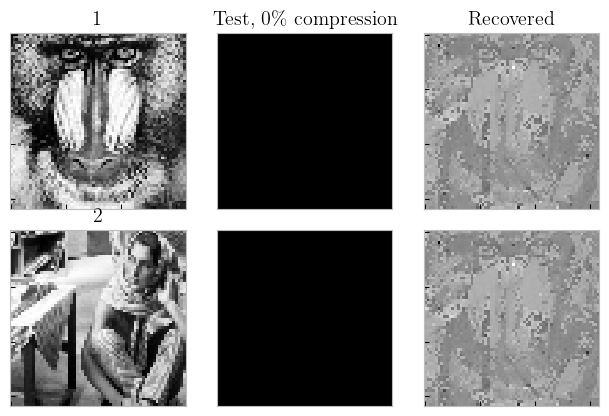

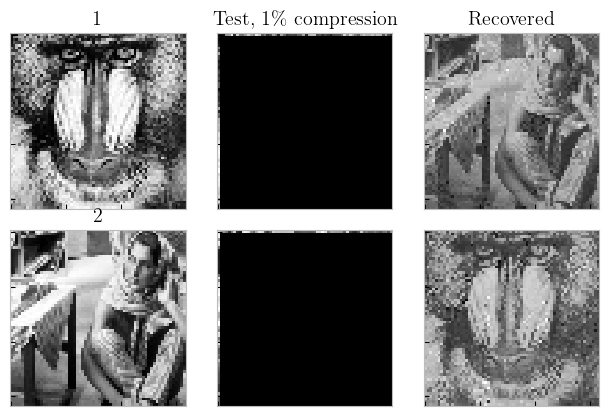

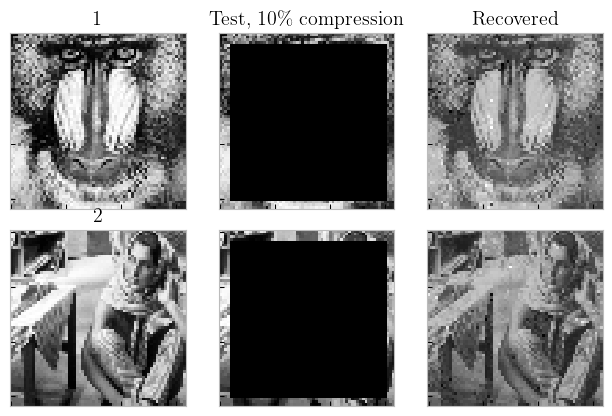

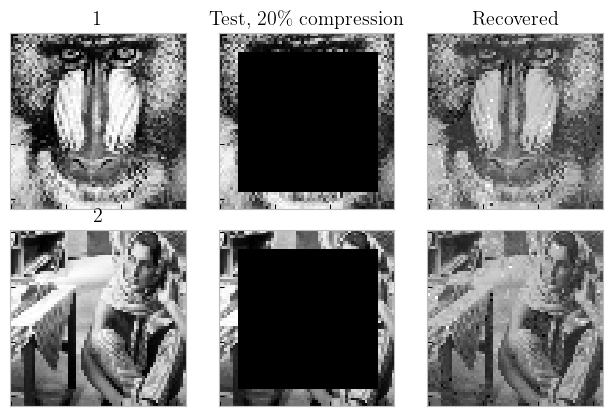

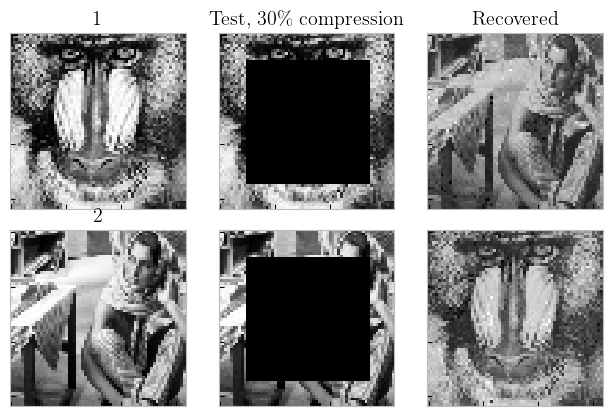

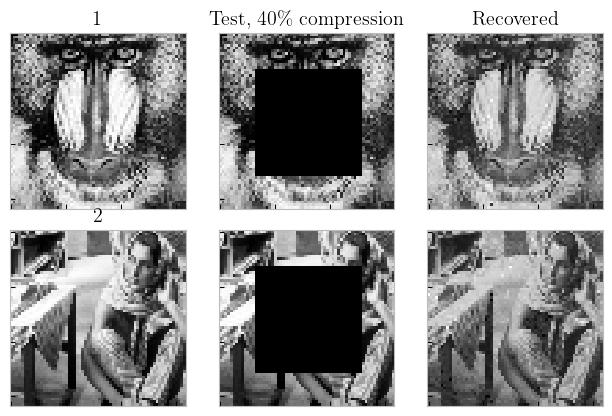

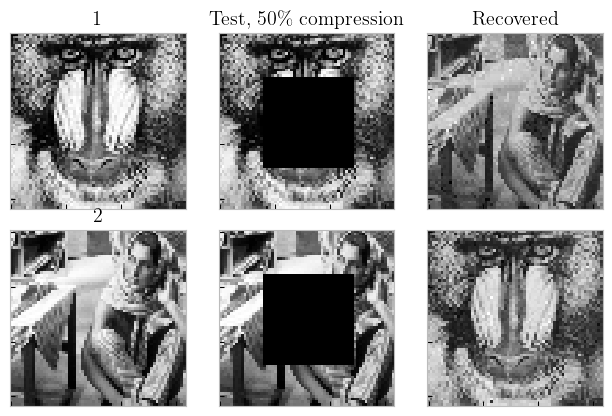

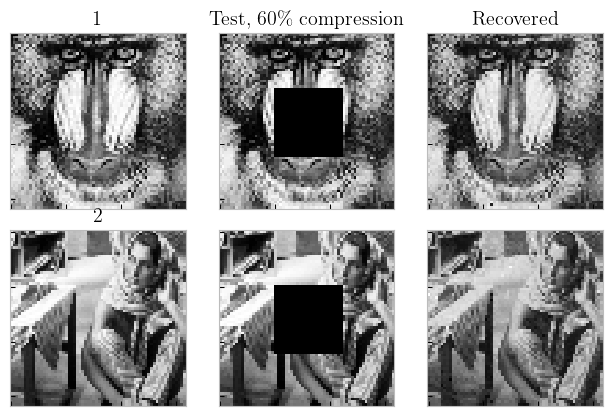

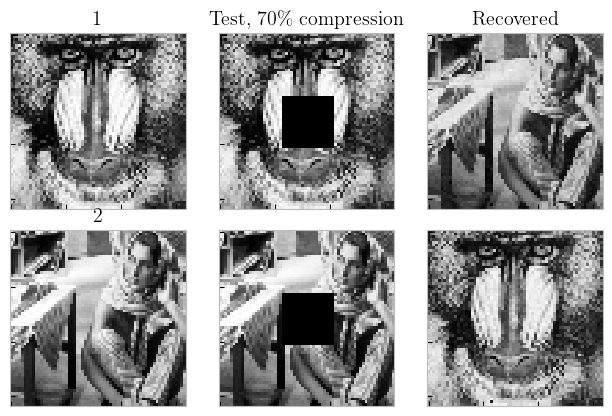

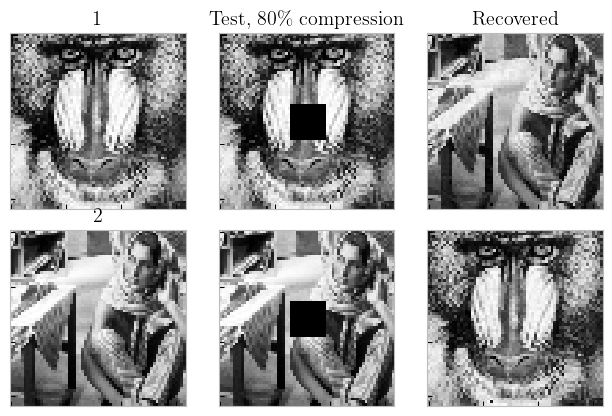

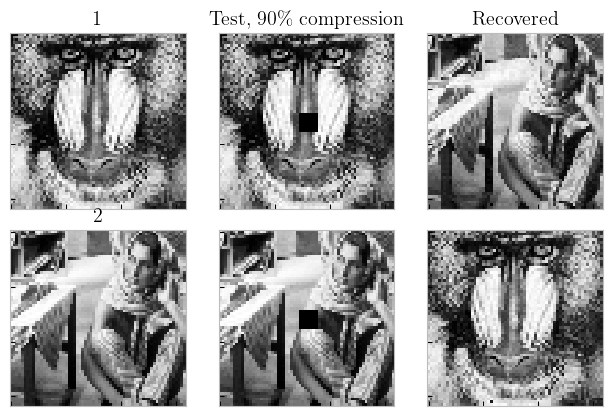

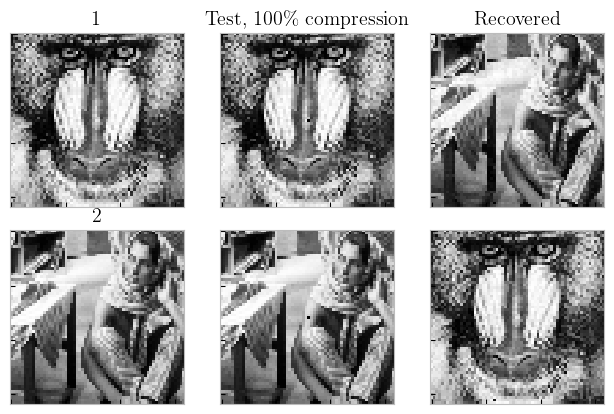

In [23]:
for p in np.concatenate(([0.0, 0.01], np.arange(0.1, 1.1, 0.1))):
    X_test = X_train.copy()
#     mask = rand.choice([0, 1], size=X_test.shape[1:], p=(1-p, p))
    mask = np.ones((X_test.shape[1:]))
    L = len(mask)
    border_size = int(L*(1 - p))//2
    mask[L//2-border_size : L//2+border_size+1, 
         L//2-border_size : L//2+border_size+1] = 0
    X_test = np.array([X_test[i] * mask for i in range(len(X_test))])
    
    test_datagen = test_gen.flow(X_test,
                                 X_test,
                                 batch_size=batch_size)
    test_ds = tfdata_generator(test_datagen)
    preds = model.predict(test_ds, steps=len(X_train)//batch_size, verbose=0)
    preds -= preds.min()
    preds /= preds.max()
    preds *= 255
    
    fig, ax = plt.subplots(cap, 3, figsize=(6, cap*2))
    if cap == 1:
        ax = np.expand_dims(ax, 0)
    for i in range(cap):
        if i == 0:
            ax[i, 0].set_title('Train')
            ax[i, 1].set_title('Test, {}\% compression'.format(int(p*100)))
            ax[i, 2].set_title('Recovered')
        ax[i, 0].imshow(X_train[i,:,:,0], 'gray')
        ax[i, 0].grid(0)
        ax[i, 0].set_title(str(i+1))
        ax[i, 0].set_xticklabels([])
        ax[i, 0].set_yticklabels([])
        ax[i, 1].imshow(X_test[i,:,:,0], 'gray')
        ax[i, 1].grid(0)
        ax[i, 1].set_xticklabels([])
        ax[i, 1].set_yticklabels([])
        ax[i, 2].imshow(preds[i,:,:,0], 'gray')
        ax[i, 2].grid(0)
        ax[i, 2].set_xticklabels([])
        ax[i, 2].set_yticklabels([])

    plt.grid(False)
    plt.tight_layout(pad=0.2)
#     plt.savefig(sessiondir + '2inputs_border{}pc.png'.format(int(p*100)),
#                 dpi=300,
#                 bbox_inches='tight')
    plt.show()

In [24]:
W, b = model.get_weights()

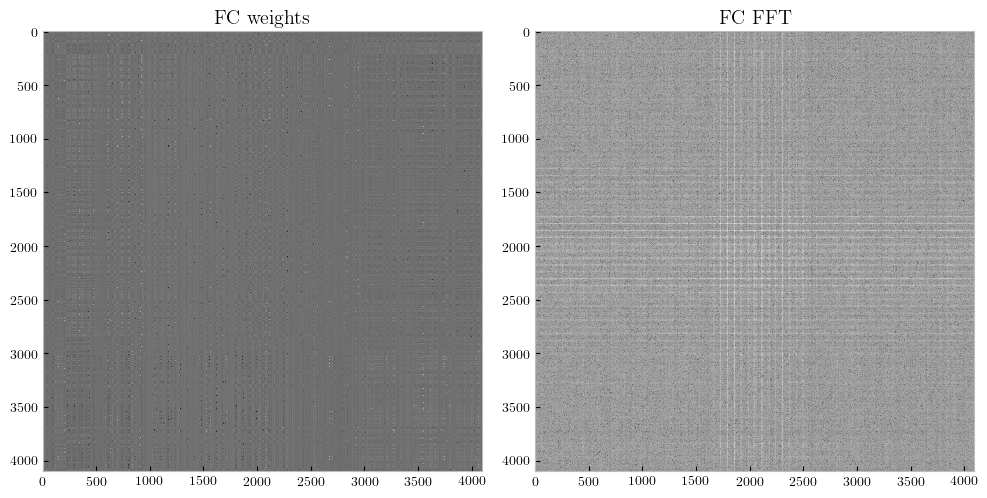

In [25]:
plt.figure(figsize=(5*2, 5))

plt.subplot(121)
plt.imshow(W, 'gray')
plt.title('FC weights')
plt.grid(0)

plt.subplot(122)
plt.imshow(np.log10(abs(fft.fftshift(fft.fft2(W)))), 'gray')
plt.title('FC FFT')
plt.grid(0)

plt.tight_layout()
# plt.savefig(sessiondir + '2input_weights.png', dpi=300, bbox_inches='tight')
plt.show()

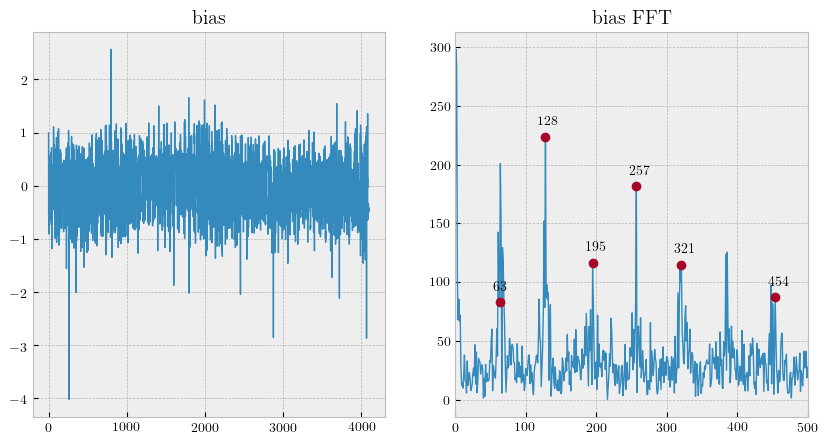

In [87]:
plt.figure(figsize=(5*2, 5))

plt.subplot(121)
plt.plot(b, lw=1)
plt.title('bias')

plt.subplot(122)
Fb = fft.fft(b)
pk = peakutils.indexes(Fb, thres=75, min_dist=10, thres_abs=True)
plt.plot(abs(Fb), lw=1)
plt.plot(pk, abs(Fb)[pk], 'o')
plt.title('bias FFT')
plt.xlim(0, 500)
for p in pk:
    if p >= 500:
        break
    plt.text(p-10, abs(Fb)[p]+10, str(p))

# plt.savefig(sessiondir + '2input_bias.png', dpi=300, bbox_inches='tight')
plt.show()